# Imports

In [1]:
import cv2 as cv
import shutil
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
import time

# Load Image

In [2]:
def plot(img, title=None):
    plt.imshow(img, cmap='gray')
    plt.rcParams['figure.figsize'] = [5, 5]
    plt.title(title)
    plt.show()

In [3]:
img1 = cv.imread('HSV Model 1.png')
img2 = cv.imread('HSV Model 2.png')
img3 = cv.imread('HSV Model 3.jpg')
img4 = cv.imread('HSV.tiff')

resized_img1 = cv.resize(img1, (500, 500))
resized_img2 = cv.resize(img2, (500, 500))
resized_img3 = cv.resize(img3, (500, 500))

img = np.hstack((resized_img1, resized_img2, resized_img3))

yellow_test = cv.imread('yellow_test.png')
test_rgb = cv.cvtColor(yellow_test, cv.COLOR_BGR2RGB)

rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

In [4]:
mypath = 'train'

classes = [str(i).zfill(3) for i in range(0, 60)]

files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files = [f for f in files if f.endswith('.png')]

for i in range(len(files)):
    if files[i][:3] in classes:
        
        # create a folder for each class
        folderName = files[i][:3]
        if folderName == '000': folderName = mypath + '/' + '0'
        else: folderName = mypath + '/' + folderName.lstrip('0')
        if not os.path.exists(folderName): os.mkdir(folderName)
        
        # move the file to the corresponding folder
        shutil.move(mypath + '/' + files[i], folderName + '/' + files[i])


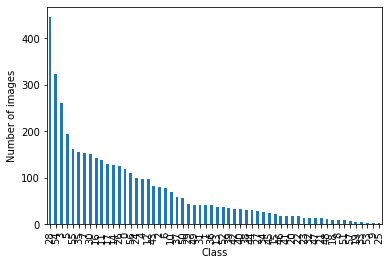

In [5]:
# remove .DS_Store file
if os.path.exists(mypath + '/.DS_Store'): os.remove(mypath + '/.DS_Store')

# convert text file to csv file
textFile = 'TsignRecgTrain4170Annotation.txt'
csvFile = 'TSDR_Labels.csv'

header = ['filename', 'width', 'height', 'x1', 'y1', 'x2', 'y2', 'class']
data = pd.read_csv(textFile, sep=';', header=None, index_col=False, names=header)
data.to_csv(csvFile, index=False)

# plot a table of the number of images per class
data['class'].value_counts().plot(kind='bar')
# size of the plot
plt.rcParams['figure.figsize'] = [20, 10]
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.show()

In [6]:
images = []
for i in range(len(data)):
    images.append(cv.imread('tsrd-train/' + data.iloc[i]['filename']))

# Randomly Choose an image

In [805]:
def random_img(idx=None, filename=None):
    
    if filename is None:
        idx = np.random.randint(0, len(data)-1) if idx is None else idx
    else:
        idx = data[data['filename'] == filename].index[0]

    
    img = images[idx]
    print(f'idx = {idx}')
    return idx, img

idx, img = random_img()

idx = 2915


# Pre-process

## HSV color range threshold

In [539]:
# k means clustering
def k_means(img, k=3):
    # convert image to grayscale
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # convert image to float32
    img = np.float32(img)
    # apply k means clustering
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv.kmeans(img, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
    # convert back to uint8
    center = np.uint8(center)
    res = center[label.flatten()]
    return res

# hsv histogram equalization
def hsv_equalize(img):
    # convert image to hsv
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    # split hsv channels
    h, s, v = cv.split(hsv)
    # equalize h channel
    # s = cv.equalizeHist(s)
    v = cv.equalizeHist(v)
    # merge hsv channels
    hsv = cv.merge((h, s, v))
    # convert back to rgb
    rgb = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    return rgb

idx = 3135


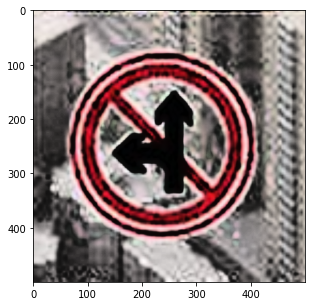

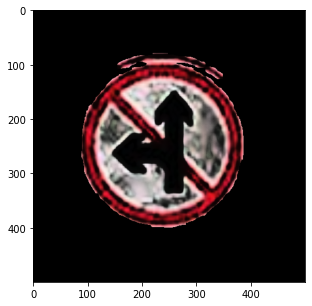

In [1629]:
def red_mask(hsv):
    low_lower_red = np.array([0, 120, 0])
    low_upper_red = np.array([8, 255, 255])

    high_lower_red = np.array([160, 80, 0])
    high_upper_red = np.array([180, 255, 255])

    red_low = cv.inRange(hsv, low_lower_red, low_upper_red)
    red_high = cv.inRange(hsv, high_lower_red, high_upper_red)
    mask = red_low + red_high
    mask = cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
    
    # morphological opening (remove small objects from the foreground)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=4)
    # erode = cv.erode(mask, np.ones((5, 5), np.uint8), iterations=13)
    # mask = cv.dilate(mask, kernel, iterations=3)
    # mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel, iterations=8)
    mask = remove_small_objects(mask)
    
    # Flood fill
    im_th = cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
    im_floodfill = im_th.copy()
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv.floodFill(im_floodfill, mask, (0, 0), 255)
    im_floodfill_inv = cv.bitwise_not(im_floodfill)
    im_out = im_th | im_floodfill_inv
    im_out = remove_small_objects(im_out)
    return im_out

img = random_img(3135)[1]
img = cv.resize(img, (500, 500))
img = hsv_equalize(img)
plot(cv.cvtColor(img, cv.COLOR_BGR2RGB))
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
rgb_ = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plot(cv.bitwise_and(rgb_, rgb_, mask=red_mask(hsv)))


idx = 1548


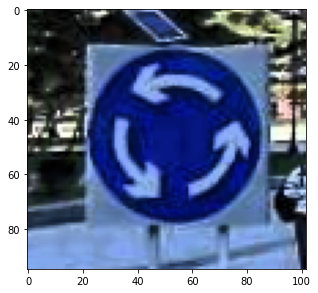

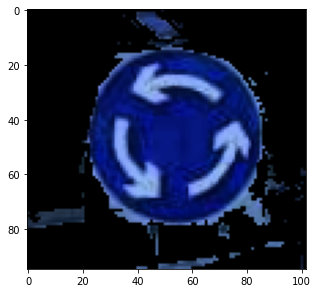

In [1683]:
def blue_mask(hsv):
    lower_blue = np.array([79, 125, 45])
    upper_blue = np.array([140, 255, 255])
    mask = cv.inRange(hsv, lower_blue, upper_blue)
    mask = cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
    # morphological opening (remove small objects from the foreground)
    # kernel = np.ones((3, 3), np.uint8)
    # mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=2)
    # erode = cv.erode(mask, np.ones((5, 5), np.uint8), iterations=13)
    # mask = cv.dilate(mask, kernel, iterations=1)
    # mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel, iterations=5)
    
    # Flood fill
    im_th = cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
    im_floodfill = im_th.copy()
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv.floodFill(im_floodfill, mask, (0, 0), 255)
    im_floodfill_inv = cv.bitwise_not(im_floodfill)
    im_out = im_th | im_floodfill_inv
    # im_out = remove_small_objects(im_out)
    return im_out

img = random_img(1548)[1]
img = hsv_equalize(img)
plot(cv.cvtColor(img, cv.COLOR_BGR2RGB))
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
rgb_ = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plot(cv.bitwise_and(rgb_, rgb_, mask=blue_mask(hsv)))

idx = 861


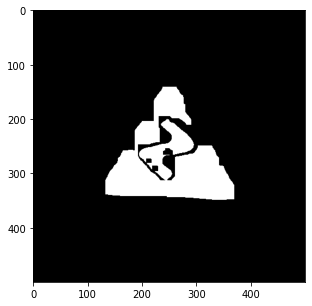

In [1405]:
# remove small objects 
def remove_small_objects(mask):
    contours, hierarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv.contourArea(cnt) < 5000:
            cv.drawContours(mask, [cnt], 0, 0, -1)
    return mask

img = random_img(861)[1]
img = cv.resize(img, (500, 500))
mask = yellow_mask(img)
mask = remove_small_objects(mask)
plot(mask)

idx = 1863


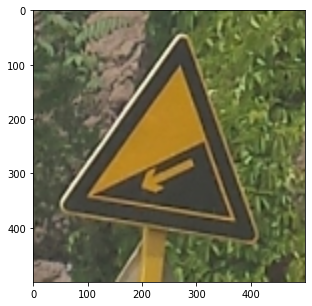

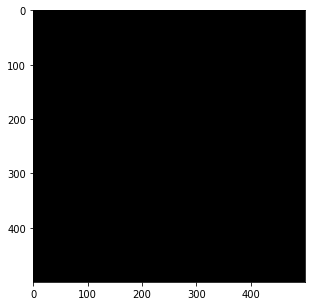

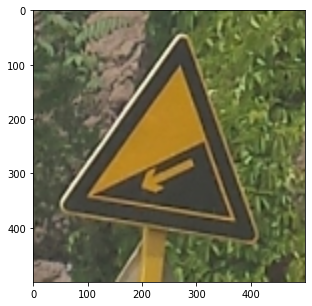

In [1665]:
def yellow_mask(img):
    img_h = img.copy()
    img = hsv_equalize(img)
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    kernel = np.ones((3, 3), np.uint8)
    mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
    
    lower_yellow = np.array([10, 130, 50])
    upper_yellow = np.array([50, 255, 255])
    yellow_mask = cv.inRange(hsv, lower_yellow, upper_yellow)
    yellow_mask = cv.morphologyEx(yellow_mask, cv.MORPH_OPEN, kernel, iterations=4)
    yellow_mask = remove_small_objects(yellow_mask)
    yellow_copy = yellow_mask.copy()
    yellow_copy = cv.erode(yellow_copy, np.ones((5, 5), np.uint8), iterations=2)
    yellow_copy = cv.morphologyEx(yellow_copy, cv.MORPH_OPEN, kernel, iterations=2)
    yellow_copy = cv.dilate(yellow_copy, np.ones((3, 3), np.uint8), iterations=10)
    yellow_copy = cv.morphologyEx(yellow_copy, cv.MORPH_CLOSE, kernel, iterations=10)
    mask = yellow_mask + yellow_copy
    
    # # # # cvInRangeS(imgHSV, cvScalar(0, 0, 0, 0), cvScalar(180, 255, 30, 0), imgThreshold) equaivalent
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([180, 255, 55])
    black_mask = cv.inRange(hsv, lower_black, upper_black)
    black_mask = cv.morphologyEx(black_mask, cv.MORPH_ERODE, kernel, iterations=6)
    # black_mask = cv.morphologyEx(black_mask, cv.MORPH_OPEN, kernel, iterations=4)
    # black_mask = cv.morphologyEx(black_mask, cv.MORPH_CLOSE, kernel, iterations=10)
    # black_mask = cv.dilate(black_mask, np.ones((3, 3), np.uint8), iterations=10)
    # black_mask = remove_small_objects(black_mask)
    mask = cv.bitwise_or(mask, black_mask)
    
    
    
    # # white mask
    lower_white = np.array([0, 0, 215])
    upper_white = np.array([180, 40, 255])
    white_mask = cv.inRange(hsv, lower_white, upper_white)
    # white_mask = remove_small_objects(white_mask)
    white_mask = cv.dilate(white_mask, kernel, iterations=8)
    # white_mask = cv.morphologyEx(white_mask, cv.MORPH_CLOSE, kernel, iterations=10)
    mask = cv.bitwise_or(mask, white_mask)

    # morphological opening (remove small objects from the foreground)
    # mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=1)
    # # mask = cv.erode(mask, np.ones((5, 5), np.uint8), iterations=1)
    # mask = cv.dilate(mask, kernel, iterations=5)
    # mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel, iterations=3)
    
    # # Flood fill
    im_th = cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
    im_floodfill = im_th.copy()
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv.floodFill(im_floodfill, mask, (0, 0), 255)
    im_floodfill_inv = cv.bitwise_not(im_floodfill)
    im_out = im_th | im_floodfill_inv
    
    im_out = cv.morphologyEx(im_out, cv.MORPH_ERODE, kernel, iterations=8)
    im_out = remove_small_objects(im_out)
    im_out = cv.morphologyEx(im_out, cv.MORPH_DILATE, kernel, iterations=10)

    return im_out
    # return mask

img = random_img(1863)[1]
img = cv.resize(img, (500, 500))
# img = hsv_equalize(img)
rgb_ = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plot(cv.cvtColor(img, cv.COLOR_BGR2RGB))
# hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
rgb_ = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plot(yellow_mask(img))
plot(cv.bitwise_and(rgb_, rgb_, mask=yellow_mask(img)))


idx = 861


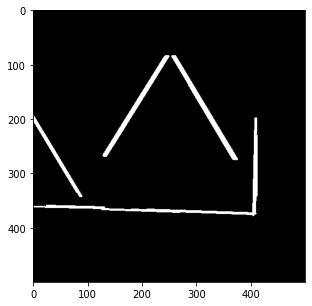

In [1411]:
# triangle hough transform detect triangle return mask 
def triangle_hough_transform(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray, 50, 150, apertureSize=3)
    # morph
    kernel = np.ones((3, 3), np.uint8)
    edges = cv.morphologyEx(edges, cv.MORPH_DILATE, kernel, iterations=2)
    edges = cv.morphologyEx(edges, cv.MORPH_OPEN, kernel, iterations=2)
    edges = cv.morphologyEx(edges, cv.MORPH_CLOSE, kernel, iterations=5)
    lines = cv.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)
    mask = np.zeros(img.shape[:2], np.uint8)
    if lines is None:
        return mask, False
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv.line(mask, (x1, y1), (x2, y2), 255, 2)
        
    # flood fill
    im_th = cv.threshold(mask, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
    im_floodfill = im_th.copy()
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv.floodFill(im_floodfill, mask, (0, 0), 255)
    im_floodfill_inv = cv.bitwise_not(im_floodfill)
    im_out = im_th | im_floodfill_inv
    return im_out, True


img = random_img(861)[1]
img = cv.resize(img, (500, 500))
plot(triangle_hough_transform(img)[0])

    

idx = 1863


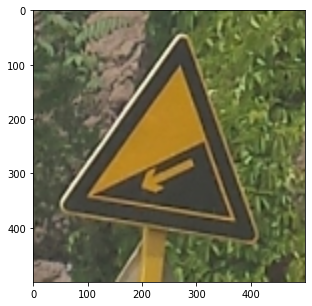

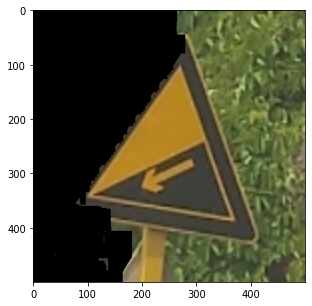

In [1554]:
def hsv_color_range_threshold(hsv):
    mask = red_mask(hsv) + blue_mask(hsv) + yellow_mask(hsv)
    return cv.threshold(mask, 0, 255, cv.THRESH_BINARY)[1]

img = random_img(1863)[1]
img = cv.resize(img, (500, 500))
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
plot(cv.cvtColor(img, cv.COLOR_BGR2RGB))
rgb_ = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plot(cv.bitwise_and(rgb_, rgb_, mask=hsv_color_range_threshold(hsv)))

## HSV Hue and Saturation Thresholding

idx = 1863


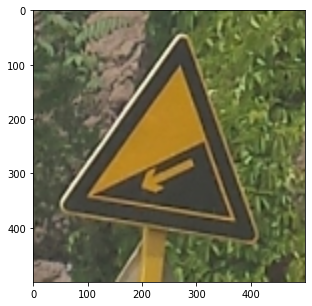

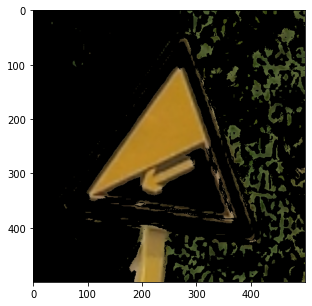

In [1558]:
def hsv_threshold(hsv):
    hsv = hsv_equalize(hsv)
    h, s, v = cv.split(hsv)

    _, h_thresh = cv.threshold(h, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    _, s_thresh = cv.threshold(s, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    _, v_thresh = cv.threshold(v, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
    thresh = cv.bitwise_and(h_thresh, s_thresh)
    thresh = (h_thresh - v_thresh) | cv.bitwise_not(s_thresh)
    thresh = cv.bitwise_not(thresh)
    # thresh = cv.erode(thresh, np.ones((7, 7), np.uint8), iterations=1)
    # # thresh = cv.morphologyEx(thresh, cv.MORPH_OPEN, np.ones((7, 7), np.uint8))
    # thresh = cv.dilate(thresh, np.ones((12, 12), np.uint8), iterations=1)
    # thresh = cv.morphologyEx(thresh, cv.MORPH_CLOSE, np.ones((15, 15), np.uint8))
    # thresh = cv.bitwise_not(thresh)
    return thresh

img = random_img(1863)[1]
img = cv.resize(img, (500, 500))
plot(cv.cvtColor(img, cv.COLOR_BGR2RGB))
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
rgb_ = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plot(cv.bitwise_and(rgb_, rgb_, mask=hsv_threshold(hsv)))

In [1547]:
def get_threshs(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    
    threshs = []
    threshs.append(red_mask(hsv))
    threshs.append(blue_mask(hsv))
    threshs.append(yellow_mask(img))
    threshs.append(hsv_threshold(hsv))
    # threshs.append(hsv_color_range_threshold(hsv))
    # threshs.append(cv.add(red_mask(hsv), blue_mask(hsv)))
    
    
    for i in range(len(threshs)):
        # threshs[i] = cv.bitwise_not(threshs[i])
        h, w = threshs[i].shape[:2]
        thresh = threshs[i]
        # thresh = cv.erode(thresh, np.ones((5,5), np.uint8), iterations=1)
        # kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
        # thresh = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel)
        # thresh = cv.dilate(thresh, np.ones((3,3), np.uint8), iterations=1)
        # threshs[i] = cv.morphologyEx(threshs[i], cv.MORPH_CLOSE, np.ones((3,3), np.uint8))
        # mask = np.zeros((h+2, w+2), np.uint8)
        # # cv.floodFill(threshs[i], mask, (0,0), 255)
        
        # # Copy the thresholded image.
        # im_floodfill = threshs[i].copy()
        # # Mask used to flood filling.

        # # Notice the size needs to be 2 pixels than the image.
        # h, w = threshs[i].shape[:2]
        # mask = np.zeros((h+2, w+2), np.uint8)

        # # Floodfill from point (0, 0)
        # cv.floodFill(im_floodfill, mask, (0,0), 255)
            
        # # Invert floodfilled image
        # im_floodfill_inv = cv.bitwise_not(im_floodfill)
        
        # # Combine the two images to get the foreground.
        # threshs[i] = threshs[i] | im_floodfill_inv
        threshs[i] = thresh 
        # plot(threshs[i])
        
    return threshs

img = random_img(477)[1]
hsv = cv.resize(img, (500, 500))
# get_threshs(hsv)

idx = 477


In [1541]:
def get_bounding_box(thresh):
    contours, _ = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    return sorted(contours, key=cv.contourArea, reverse=True)

def get_contour(img, threshs):
    contours = []
    for i in threshs:
        for j in get_bounding_box(i):
            contours.append(j)
    height, width = img.shape[:2]
    
    cnts = []
    copy = img.copy()
    for c in contours:
        area = cv.contourArea(c)
        x, y, w, h = cv.boundingRect(c)
        ratio = w / h
        if ((w/h)<1.21 and (w/h)>0.59 and w>20):
            if w!=width and h!=height and x>0 and y>0 and w>20 and h>20 and area>1000:
                cnts.append(c)
                cv.drawContours(copy, [c], -1, (0, 255, 0), 2)
    # plot(copy)
        

    largest_contour = max(cnts, key=cv.contourArea) if cnts else None
    if largest_contour is not None:
        x, y, w, h = cv.boundingRect(largest_contour)
    else:
        x, y, w, h = 0, 0, 0, 0
    return x, y, w, h

# Display Image

In [1190]:
def pred_box(img):
    img = cv.resize(img, (500, 500))
    
    rgb = cv.cvtColor(img.copy(), cv.COLOR_BGR2RGB)
    hsv = cv.cvtColor(img.copy(), cv.COLOR_BGR2HSV)
    
    # img = cv.medianBlur(img, 9)
    # hsv = cv.bilateralFilter(hsv, 9, 75, 75)
    
    threshs = get_threshs(img)
    
    x, y, w, h = get_contour(rgb, threshs)
    rgb = cv.rectangle(rgb, (x, y), (x + w, y + h), (255, 0, 0), 4)
    return [x, y, w, h], rgb

def actual_box(idx):
    img = images[idx]
    height, width = img.shape[:2]
    x, y, w, h = data.iloc[idx]['x1'], data.iloc[idx]['y1'], data.iloc[idx]['x2'] - data.iloc[idx]['x1'], data.iloc[idx]['y2'] - data.iloc[idx]['y1']
    x, w = int(x * 500 / width), int(w * 500 / width)
    y, h = int(y * 500 / height), int(h * 500 / height)
    img = cv.resize(img, (500, 500))
    img = cv.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 4)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return [x, y, w, h], img

def test_box(filename):
    idx = data[data['filename'] == filename].index[0]
    print(idx)
    return actual_box(idx)

In [16]:
# accuracy evaluation
# The measure works by calculating the overlapping areas of intersection between two bounding boxes, divided by the total area of both bounding boxes. This produces an “accuracy score” that can be used to measure how close two bounding boxes match.

def intersection_over_union(pred, actual):
    x1, y1, w1, h1 = pred
    x2, y2, w2, h2 = actual
    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1 + w1, x2 + w2)
    yB = min(y1 + h1, y2 + h2)
    
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (w1 + 1) * (h1 + 1)
    boxBArea = (w2 + 1) * (h2 + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou * 100

# Test

idx = 1863


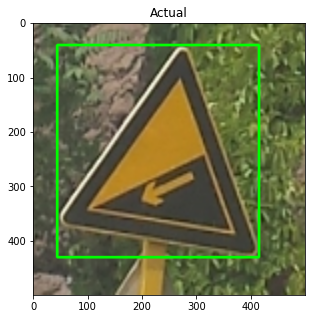

time:		23.81 ms
Accuracy:	75.75%


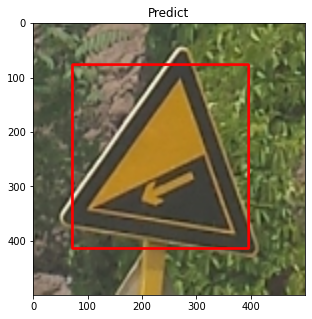

In [1662]:
idx, img = random_img(1863)
# filename = '015_1_0001.png'
# img = cv.imread('test/' + filename)

# img = hsv_equalize(img)

actualBox, actual = actual_box(idx)
plot(actual, 'Actual')

# testBox, test = test_box(filename)
# plot(test, 'Test')

start = time.perf_counter()

predBox, pred = pred_box(img)

end = time.perf_counter()
iou = intersection_over_union(predBox, actualBox)

print(f'time:\t\t{round((end - start) * 1000, 2)} ms')
print(f'Accuracy:\t{round(iou, 2)}%')

plot(pred, 'Predict')


1548


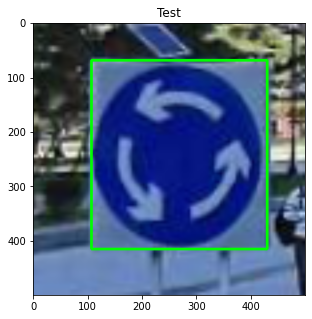

time:		27.41 ms
Accuracy:	80.04%


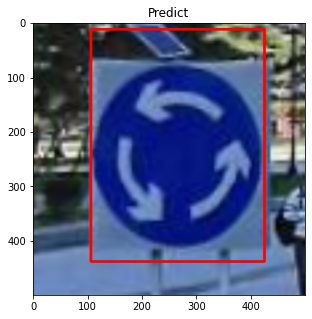

In [1684]:
filename = '027_0012.png'
img = cv.imread('test/' + filename)

# img = hsv_equalize(img)

testBox, test = test_box(filename)
plot(test, 'Test')

start = time.perf_counter()

predBox, pred = pred_box(img)

end = time.perf_counter()
iou = intersection_over_union(predBox, testBox)

print(f'time:\t\t{round((end - start) * 1000, 2)} ms')
print(f'Accuracy:\t{round(iou, 2)}%')

plot(pred, 'Predict')


In [1686]:
import time
def accuracy(data):
    acc = []
    time_ms = []
    for i in range(len(data)):
        start = time.perf_counter()
        pred = pred_box(images[i])[0]
        time_ms.append((time.perf_counter() - start)*1000)
        actual = actual_box(i)[0]
        iou = intersection_over_union(pred, actual)
        acc.append(iou)
        sys.stdout.write('\r')
        sys.stdout.write('Image {} accuracy: {:.2f}%\taverage accuracy: {:.2f}%\ttime taken: {:.2f}'.format(i, iou, np.mean(acc), np.mean(time_ms)))
        sys.stdout.write("\t[%-20s] %d%%" % ('█'*int(i/len(data)*20), 100*i/len(data)))
        sys.stdout.flush()
    print(f'\nAverage accuracy: {np.mean(acc)}%')
    print(f'Average time taken: {np.mean(time_ms)} ms')
    return acc, time_ms

accuracy, time_ms = accuracy(data)


Image 4169 accuracy: 96.40%	average accuracy: 85.26%	time taken: 15.77	[███████████████████ ] 99%%
Average accuracy: 85.25875692162084%
Average time taken: 15.774666144791349 ms


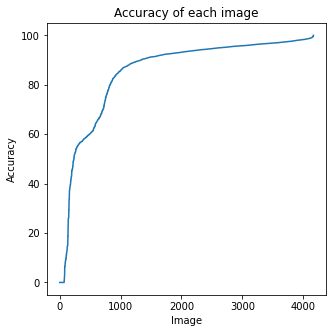

In [1687]:
plt.plot((np.sort(accuracy)))
plt.title('Accuracy of each image')
plt.xlabel('Image')
plt.ylabel('Accuracy')
plt.show()

2499
Image 0 accuracy: 95.98%2932
Image 1 accuracy: 91.15%1092
Image 2 accuracy: 93.78%2748
Image 3 accuracy: 91.29%1863
Image 4 accuracy: 39.37%3373
Image 5 accuracy: 92.07%487
Image 6 accuracy: 90.67%861
Image 7 accuracy: 90.51%3135
Image 8 accuracy: 91.90%2713
Image 9 accuracy: 96.84%2912
Image 10 accuracy: 63.04%766
Image 11 accuracy: 90.90%3924
Image 12 accuracy: 60.96%3926
Image 13 accuracy: 87.68%2672
Image 14 accuracy: 95.78%1548
Image 15 accuracy: 80.04%2112
Image 16 accuracy: 56.44%2831
Image 17 accuracy: 87.33%1387
Image 18 accuracy: 96.52%863
Image 19 accuracy: 85.38%3100
Image 20 accuracy: 95.40%2538
Image 21 accuracy: 96.83%1546
Image 22 accuracy: 98.51%2292
Image 23 accuracy: 96.07%1079
Image 24 accuracy: 45.12%2949
Image 25 accuracy: 88.60%3403
Image 26 accuracy: 96.39%3837
Image 27 accuracy: 96.37%653
Image 28 accuracy: 96.91%3086
Image 29 accuracy: 94.35%2432
Image 30 accuracy: 91.87%2751
Image 31 accuracy: 59.66%866
Image 32 accuracy: 66.67%2096
Image 33 accuracy: 63

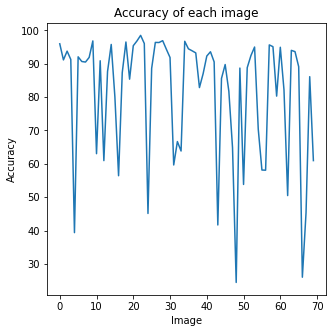

4 040_0011.png 39.37381404174573
10 043_1_0021.png 63.04324838743788
12 036_1_0014.png 60.96054204862496
16 000_1_0034.png 56.437013128837336
24 042_0016_j.png 45.12067156348373
31 034_1_0002.png 59.659520807061796
32 047_0005.png 66.67088007584137
33 000_1_0018.png 63.84243318576816
43 034_1_0003_1_j.png 41.67161814220638
47 050_1_0003.png 64.85714285714286
48 048_0004.png 24.442283650507015
50 032_1_0002_1_j.png 53.81863570669246
54 042_0002_j.png 70.3886925795053
55 036_1_0019.png 58.140483607773334
56 035_1_0003.png 58.091382301908624
62 032_1_0001_1_j.png 50.485677470512435
66 051_0005_j.png 26.009636576431426
67 045_1_0009.png 45.36324476066018
69 035_1_0004.png 60.96739900779588


In [1688]:
# load all filename of images in test folder
test_path = "test/"
filename = [f for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))]

# get x1, y1, x2, y2 of each image
test_data = pd.DataFrame(columns=['filename', 'x1', 'y1', 'x2', 'y2'])
for i in range(len(filename)):
    idx = data[data['filename'] == filename[i]].index[0]
    img = cv.imread(test_path + filename[i])
    height, width = img.shape[:2]
    x, y, w, h = data.iloc[idx]['x1'], data.iloc[idx]['y1'], data.iloc[idx]['x2'] - data.iloc[idx]['x1'], data.iloc[idx]['y2'] - data.iloc[idx]['y1']
    x, w = int(x * 500 / width), int(w * 500 / width)
    y, h = int(y * 500 / height), int(h * 500 / height)
    test_data.loc[i] = [filename[i], x, y, x+w, y+h]

test_images = []
for i in range(len(test_data)):
    img = cv.imread(test_path + test_data.iloc[i]['filename'])
    test_images.append(img)
    

# get accuracy of each image
test_accuracy = []
for i in range(len(test_data)):
    idx = data[data['filename'] == test_data.iloc[i]['filename']].index[0]
    # print(idx)
    pred, p = pred_box(test_images[i])
    test, t = test_box(test_data.iloc[i]['filename'])
    test_accuracy.append(intersection_over_union(pred, test))
    sys.stdout.write('\r')
    sys.stdout.write('Image {} accuracy: {:.2f}%'.format(i, test_accuracy[i]))
    sys.stdout.flush()
print(f'\nAverage accuracy: {np.mean(test_accuracy)}%')

# plot accuracy of each image
plt.plot((test_accuracy))
plt.title('Accuracy of each image')
plt.xlabel('Image')
plt.ylabel('Accuracy')
plt.show()

# sum of count of images with accuracy > 50%
count = 0
for i in range(len(test_accuracy)):
    if test_accuracy[i] < 80:
        print(i, end=' ', flush=True)
        print(test_data.iloc[i]['filename'], end=" ", flush=True)
        print(test_accuracy[i])

In [ ]:
acc = accuracy
acc = np.sort(acc)
plt.plot(acc)
# plt.rcParams['figure.figsize'] = [20, 10]
plt.title('Accuracy')
plt.xlabel('Image number')
plt.ylabel('Accuracy')
plt.show()

# # accuracy vs time taken
# plt.plot(time_ms, acc)
# plt.rcParams['figure.figsize'] = [5, 2]
# plt.title('Accuracy vs Time taken')
# plt.xlabel('Time taken (ms)')
# plt.ylabel('Accuracy')
# plt.show()


# 2 decimal place
print(f'\nAverage accuracy: {round(np.mean(acc), 2)}%')
print(f'Average time taken: {round(np.mean(time_ms), 2)} ms')

# how many images have accuracy >= 70%
percent = 95 
print(f'Number of images with accuracy >= {percent}%: {len([i for i in accuracy if i >= percent])}')
for i in range(len(accuracy)):
    if accuracy[i] <= 0:
        print(i, end=' ')
        

In [ ]:
plot(cv.cvtColor(random_img(477)[1], cv.COLOR_BGR2RGB), 'Random image')

In [ ]:
def accuracy_class(acc):
    class_acc = {'class': [], 'accuracy': []}
    for i in range(58):
        class_idx = data[data['class'] == i].index
        class_acc['class'].append(i)
        class_acc['accuracy'].append(np.mean([acc[j] for j in class_idx]))
    return class_acc

def plot_accuracy(acc, class_number):
    class_idx = data[data['class'] == class_number].index
    class_acc = [accuracy[i] for i in class_idx]
    class_acc = np.sort(class_acc)
    plt.plot(class_acc)
    plt.title(f'Class {class_number} accuracy')
    plt.xlabel('Image number')
    plt.ylabel('Accuracy')
    plt.show()


In [ ]:
class_acc = accuracy_class(acc)
sort = np.argsort(class_acc['accuracy'])
    
print('\nTop 10 classes with lowest accuracy:')
for i in sort[:10]:
    print(f'Class {class_acc["class"][i]} accuracy: {class_acc["accuracy"][i]}')

plot_accuracy(accuracy, 1)

In [ ]:
# Crop pred box
def crop_pred(idx):
    img = images[idx]
    pred = pred_box(img)[0]
    x, y, w, h = pred
    # resize to 500x500
    img = cv.resize(img, (500, 500))
    img = img[y:y+h, x:x+w]
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img
plot(crop_pred(random_img()[0]), 'Cropped')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization

# create a CNN that output for 58 class
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(500, 500, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=1024, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=58, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
    

In [ ]:
# LeNet-5 CNN 
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(500, 500, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units=58, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()